## HW 2 Computer Vision

#### Notice that the report of each question is under the result of it(after visualizing each outputs)

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage import exposure
from skimage.feature import hog
from skimage.metrics import peak_signal_noise_ratio as PSNR, mean_squared_error as MSE

### Load Photos

In [2]:
def load_dataSet(path):
    
    images = []
    photosPath = path
    
    for root, dirs, files in os.walk(photosPath):
        for file in files:
            if file.endswith(".bmp") or file.endswith(".jpg"):
                img = cv2.imread(os.path.join(root, file))
                images.append(img)
                
    return images

### Visualize Images

In [3]:
def visualize(pictures, images=None, checkMetrics=False):
    
    num_images = len(pictures)
    num_cols = 4
    num_rows = -(-num_images // num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))

    for i, image in enumerate(pictures):
        row = i // num_cols
        col = i % num_cols
        if checkMetrics:
            psnr = PSNR(images[i], pictures[i])
            mse = MSE(images[i], pictures[i])
        if num_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]

        if isinstance(image, np.ndarray):
            if len(image.shape) == 2:
                ax.imshow(image, cmap='gray')
                if checkMetrics:
                    ax.set_title(f'psnr: {psnr:.4f}\nmse: {mse:.4f}')
            elif len(image.shape) == 3:
                if image.shape[2] == 3:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                ax.imshow(image)
                if checkMetrics:
                    ax.set_title(f'psnr: {psnr:.4f}\nmse: {mse:.4f}')
            else:
                ax.imshow(image)
                if checkMetrics:
                    ax.set_title(f'psnr: {psnr:.4f}\nmse: {mse:.4f}')
        else:
            ax.imshow(image)
        
        ax.set_axis_off()

    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        
        if num_rows > 1:
            axes[row, col].axis('off')
        else:
            axes[col].axis('off')

    plt.tight_layout()
    plt.show()


## Question 1

In [4]:
def prewitt_ED(images):
    """
    Performs Prewitt edge detection on a list of input images.

    Args:
    - images: List of input images (in BGR format)

    Returns:
    - prewitt_images: List of Prewitt edge-detected images
    """
    
    prewitt_images = []
    
    kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    
    for image in images: 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.filter2D(image, -1, kernel_x)
        grad_y = cv2.filter2D(image, -1, kernel_y)
        edge_detected = cv2.addWeighted(cv2.convertScaleAbs(grad_x), 0.5, 
                                     cv2.convertScaleAbs(grad_y), 0.5, 0)
        prewitt_images.append(edge_detected)
    
    return prewitt_images
        
images1 = load_dataSet("./images/1/")
prewitt_images = prewitt_ED(images1)

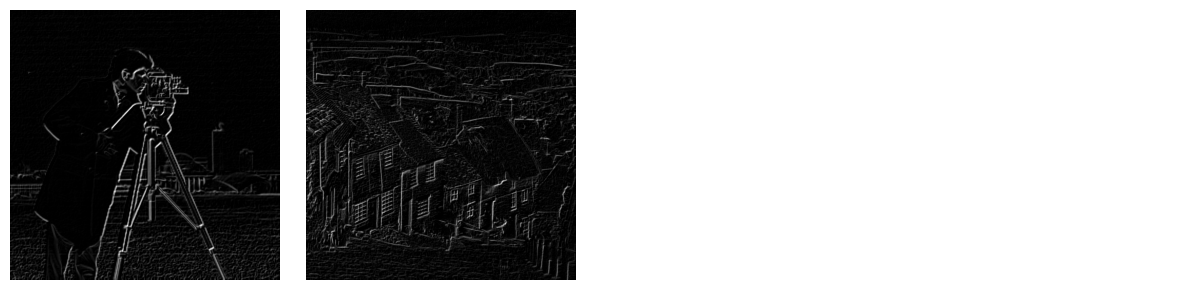

In [14]:
visualize(prewitt_images)

Prewitt edge detection is another gradient-based method for identifying edges in an image.</br>
Steps:
<ol>
    <li>Grayscale Conversion:</br>
        If the input image is in color, it is often converted to grayscale.
    </li></br>
    <li>Convolution:</br>
        The Prewitt_x and Prewitt_y kernels are convolved with the image to compute the horizontal and vertical gradients, 
        respectively.
    </li></br>
    <li>Gradient Magnitude:</br>
        The gradient magnitude at each pixel is calculated using the combined horizontal and vertical gradients.
    </li></br>
    <li>Thresholding:</br>
        A threshold is applied to the gradient magnitude to identify significant edges.</br> 
        Pixels with gradient magnitudes above a certain threshold are considered part of an edge.
    </li>
</ol>

##### the <b>prewitt</b> detector works well and it detects edges so well. In general it will amplifies noises in images but this images didn't have noise in large scale. it also detects edges in any direction.

In [15]:
def kirsch_ED(images):
    """
    Performs Kirsch edge detection on a list of input images.

    Args:
    - images: List of input images (in BGR format)

    Returns:
    - kirsch_images: List of Kirsch edge-detected images
    """
    
    kirsch_images = []
    
    # Define Kirsch masks for edge detection in 8 directions
    KIRSCH_K1   = np.array([[ 5, -3, -3], [ 5,  0, -3], [ 5, -3, -3]], dtype=np.float32) / 15
    KIRSCH_K2   = np.array([[-3, -3,  5], [-3,  0,  5], [-3, -3,  5]], dtype=np.float32) / 15
    KIRSCH_K3   = np.array([[-3, -3, -3], [ 5,  0, -3], [ 5,  5, -3]], dtype=np.float32) / 15
    KIRSCH_K4   = np.array([[-3,  5,  5], [-3,  0,  5], [-3, -3, -3]], dtype=np.float32) / 15
    KIRSCH_K5   = np.array([[-3, -3, -3], [-3,  0, -3], [ 5,  5,  5]], dtype=np.float32) / 15
    KIRSCH_K6   = np.array([[ 5,  5,  5], [-3,  0, -3], [-3, -3, -3]], dtype=np.float32) / 15
    KIRSCH_K7   = np.array([[-3, -3, -3], [-3,  0,  5], [-3,  5,  5]], dtype=np.float32) / 15
    KIRSCH_K8   = np.array([[ 5,  5, -3], [ 5,  0, -3], [-3, -3, -3]], dtype=np.float32) / 15
    
    for image in images:
        
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Kirsch masks to detect edges in 8 directions and take the maximum response
        edges    = np.maximum(cv2.filter2D(image, cv2.CV_8U, KIRSCH_K1),
              np.maximum(cv2.filter2D(image, cv2.CV_8U, KIRSCH_K2),
              np.maximum(cv2.filter2D(image, cv2.CV_8U, KIRSCH_K3),
              np.maximum(cv2.filter2D(image, cv2.CV_8U, KIRSCH_K4),
              np.maximum(cv2.filter2D(image, cv2.CV_8U, KIRSCH_K5),
              np.maximum(cv2.filter2D(image, cv2.CV_8U, KIRSCH_K6),
              np.maximum(cv2.filter2D(image, cv2.CV_8U, KIRSCH_K7),
                            cv2.filter2D(image, cv2.CV_8U, KIRSCH_K8),
                           )))))))
        
        kirsch_images.append(edges)
    
    return kirsch_images
        
kirsch_images = kirsch_ED(images1)

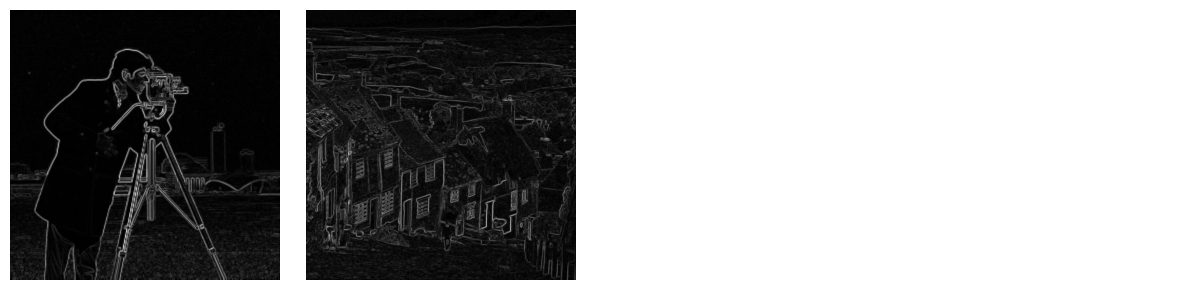

In [16]:
visualize(kirsch_images)

The Kirsch masks are convolution masks used for edge detection.</br>
They are rotated versions of the basic Sobel masks and are designed to detect edges at different orientations.</br>
Kirsch Edge Detection Process:
<ol>
    <li>The eight masks are convolved with the image.</li></br>
    <li>For each pixel, the maximum gradient magnitude across all eight convolutions is computed.</li></br>
    <li>The resulting magnitude values are used to create the edge-detected image.</li>
</ol>

##### the <b>kirsch</b> detector detects edges better than the prewitt and it didn't amplifies the noise compared to prewitt but in general it will amplifies them. the quality of edges is better here

In [17]:
def Marr_Hildreth_ED(images, sigma=1.4, threshold=0.5):
    """
    Performs Marr-Hildreth edge detection on a list of input images.

    Args:
    - images: List of input images (in BGR format)
    - sigma: Standard deviation for Gaussian smoothing (default: 1.4)
    - threshold: Threshold value for edge detection (default: 0.5)

    Returns:
    - MH_images: List of Marr-Hildreth edge-detected images
    """
    
    MH_images = []
    
    for image in images:
        
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian smoothing
        smoothed_image = cv2.GaussianBlur(image, (5, 5), sigma)
        
        # Compute the Laplacian of the smoothed image
        laplacian = cv2.Laplacian(smoothed_image, cv2.CV_64F)
        
        # Find zero crossings in the Laplacian image
        edges = np.zeros_like(laplacian)
        rows, cols = laplacian.shape
        
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                neighbors = [laplacian[i-1, j], laplacian[i+1, j], laplacian[i, j-1], laplacian[i, j+1],
                            laplacian[i-1, j-1], laplacian[i-1, j+1], laplacian[i+1, j-1], laplacian[i+1, j+1]]
                if any(np.sign(neighbors[:-1]) != np.sign(neighbors[1:])):
                    edges[i, j] = 255
        
        edges = 255 - edges
                    
        # Apply thresholding to the edge image
        edges[edges >= (threshold * 255)] = 255
        edges[edges < (threshold * 255)] = 0
        
        MH_images.append(edges.astype(np.uint8))
              
    return MH_images

MH_images = Marr_Hildreth_ED(images1)

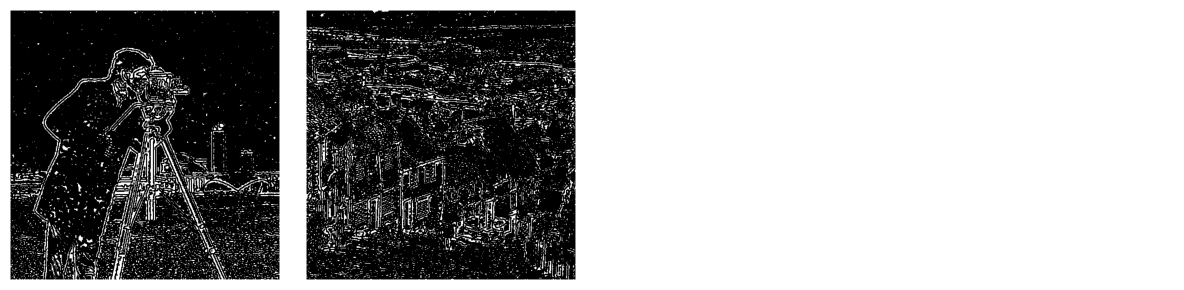

In [18]:
visualize(MH_images)

The Marr-Hildreth (or LoG-Laplacian of Gaussian) edge detection algorithm is an edge detection method that combines the use of Gaussian smoothing and the Laplacian operator to identify edges in an image.</br>
steps:
<ol>
    <li>Gaussian Smoothing:</br>
        Convolve the input image with a Gaussian filter to reduce noise and eliminate small-scale structures.</br>
        The choice of the standard deviation (σ) of the Gaussian determines the amount of smoothing.
    </li></br>
    <li>Laplacian Operator:</br>
        Apply the Laplacian operator to the smoothed image to highlight regions with rapid intensity changes.
    </li></br>
    <li>Zero-Crossing Detection:</br>
        Identify zero-crossings in the Laplacian image. A zero-crossing occurs where the intensity changes sign.</br>
        Zero-crossings correspond to potential locations of edges in the original image
    </li></br>
    <li>Thresholding:</br>
        Apply thresholding to the zero-crossings to classify pixels into edge and non-edge pixels.</br>
        This step helps in distinguishing actual edges from noise.
    </li>
</ol>

##### the <b>Marr_Hildreth</b> algorithm detects the edges  worse than 2 previous algorithms but it is robust to rotation and it is for multiScale analysis. but it amplifies the noise so much and it gives thicker edges compare to prewitt and kirsch and it's also so complex and it takes too long to compute the result.

In [19]:
def canny_ED(images, min_threshold=100, max_threshold=200):
    """
    Performs Canny edge detection on a list of input images.

    Args:
    - images: List of input images (in BGR format)
    - min_threshold: Minimum threshold value (default: 100)
    - max_threshold: Maximum threshold value (default: 200)

    Returns:
    - canny_images: List of Canny edge-detected images
    """
    
    canny_images = []
    
    for image in images:
        
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Canny edge detection
        edges = cv2.Canny(image, min_threshold, max_threshold)
        
        canny_images.append(edges)
    
    return canny_images

canny_images = canny_ED(images1)

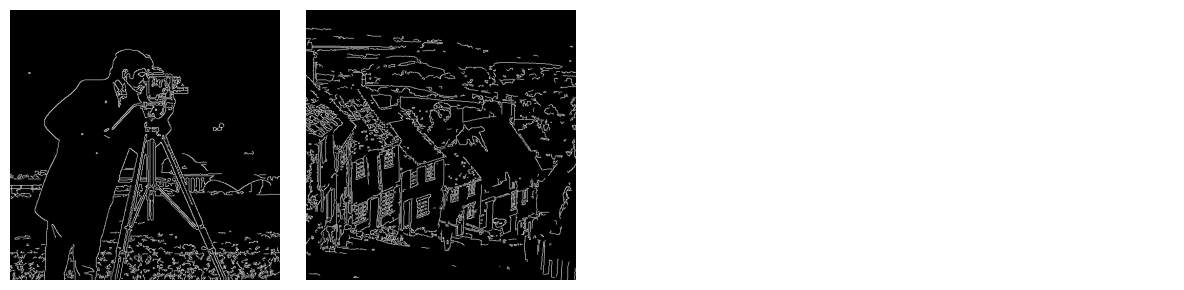

In [20]:
visualize(canny_images)

 Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed.</br>
 steps:
 <ol>
    <li>Gaussian Smoothing:</br>
        Convolve the input image with a Gaussian filter to reduce noise and suppress small details. 
        This step helps in creating a smoother image, which is beneficial for the accuracy of subsequent gradient calculations.
    </li></br>
    <li>Gradient Calculation:</br>
        Compute the gradient of the image using convolution with Sobel operators in both the horizontal and vertical directions.
    </li></br>
    <li>Non-Maximum Suppression:</br>
        Identify local maxima in the gradient direction.</br>
        For each pixel, compare its gradient magnitude with the magnitudes of its neighbors in the gradient direction.</br>
        If the pixel's magnitude is the maximum, keep it; otherwise, set it to zero. This step results in a thinned edge map.</br>
        Only the local maxima in the gradient direction are retained, while other non-maximum values are suppressed. 
    </li></br>
    <li>Double Thresholding:</br>
        Apply double thresholding to classify pixels into three categories:</br>
        Strong Edges: Pixels with gradient magnitudes above a high threshold.</br>
        Weak Edges: Pixels with gradient magnitudes between high&low thresholds.</br>
        Non-Edges: Pixels with gradient magnitudes below a low threshold.
    </li>
</ol>
 

##### <b>canny</b> algorithm is the best algorithm for edge detection between this four algorithms. It detects edges so well and it didn't amplifies the noise here. but if we have large scale of noise this algorithm won't act well.

## Question 2

In [7]:
def segment_colors(images, num_colors):
    """
    Segments the colors in a list of images using K-means clustering.

    Args:
    - images: List of input images
    - num_colors: Number of colors for segmentation

    Returns:
    - segmented_images: List of segmented images
    """

    segmented_images = []
    
    for image in images:
        
        # Reshape image pixels to a 2D array
        pixels = image.reshape(-1, 3)
        pixels = np.float32(pixels)
        
        # Set criteria for K-means clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
        
        # Apply K-means clustering
        retval, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert centers to uint8
        centers = np.uint8(centers)
        
        # Retrieve segmented data based on the labels
        segmented_data = centers[labels.flatten()]
        
        # Reshape the segmented data to the original image shape
        segmented_image = segmented_data.reshape((image.shape))
        
        segmented_images.append(segmented_image)
    
    return segmented_images

images2 = load_dataSet("./images/2")
# Perform segmentation with different numbers of colors
segmented_8_colors = segment_colors(images2, 8)
segmented_16_colors = segment_colors(images2, 16)
segmented_32_colors = segment_colors(images2, 32)


#### Segmentation with 8 colors:

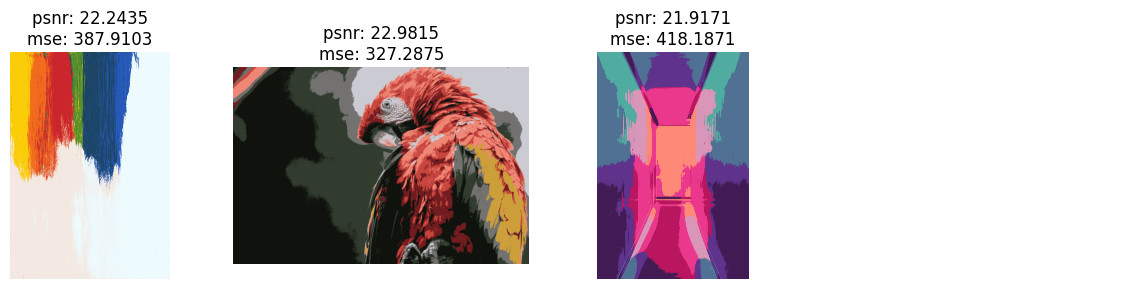

In [25]:
visualize(segmented_8_colors, images2, checkMetrics=True)

#### segmentation with 16 colors:

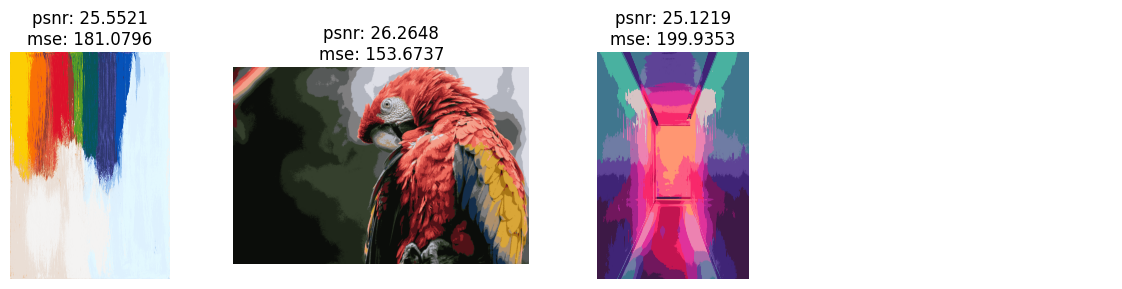

In [26]:
visualize(segmented_16_colors, images2, checkMetrics=True)

#### Segmentation with 32 colors:

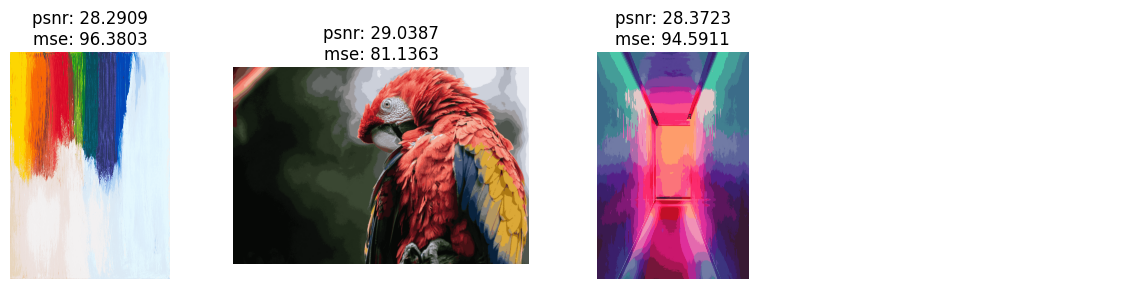

In [27]:
visualize(segmented_32_colors, images2, checkMetrics=True)

Image segmentation is the task of finding groups of pixels that “go together”.</br>
Clustering-based segmentation:
<ul>
    <li>Involves grouping pixels into clusters using clustering algorithmslike k-Means.</li>
    <li> Assumes that pixels belonging to the same cluster share similar characteristics.</li>
</ul>
steps:
<ol>
    <li>First, randomly select k initial clusters</li></br>
    <li>Randomly assign each data point to any one of the k clusters</li></br>
    <li>Calculate the centers of these clusters</li></br>
    <li>Calculate the distance of all the points from the center of each cluster</li></br>
    <li>Depending on this distance, the points are reassigned to the nearest cluster</li></br>
    <li>Calculate the center of the newly formed clusters</li></br>
    <li>Finally, repeat steps 4, 5 and 6 until either the center of the clusters does not change or we reach the set number of iterations</li>
</ol>

#### as you can see, when we increase the number of colors in image, psnr increase and mse decrease. it means that the similarity between two images has increased and the output is more similar compare to input.

## Question 3

In [6]:
def gabor_segmentation(images, ksize=9, sigma=4.0, theta=0, lambd=10.0, gamma=0.5):
    """
    Performs texture-based segmentation using Gabor filters on a list of input images.

    Args:
    - images: List of input images (in grayscale format)
    - ksize: Size of the Gabor kernel (default: 9)
    - sigma: Standard deviation of the Gaussian envelope (default: 4.0)
    - theta: Orientation of the normal to the parallel stripes of a Gabor function (default: 0)
    - lambd: Wavelength of the sinusoidal factor (default: 10.0)
    - gamma: Spatial aspect ratio (default: 0.5)

    Returns:
    - segmented_images: List of segmented images using Gabor filters
    """
    
    gabor_images = []
    
    for image in images:
        
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Gabor filter to the image
        gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma)
        filtered_image = cv2.filter2D(image, cv2.CV_32F, gabor_kernel)
        
        # Normalize the filtered image to convert to CV_8U (0-255)
        normalized_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        
        # Apply thresholding to obtain binary image for segmentation
        _, thresholded = cv2.threshold(normalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        gabor_images.append(thresholded)
    
    return gabor_images

images3 = load_dataSet("./images/3")
gabor_images = gabor_segmentation(images3, ksize=5)    

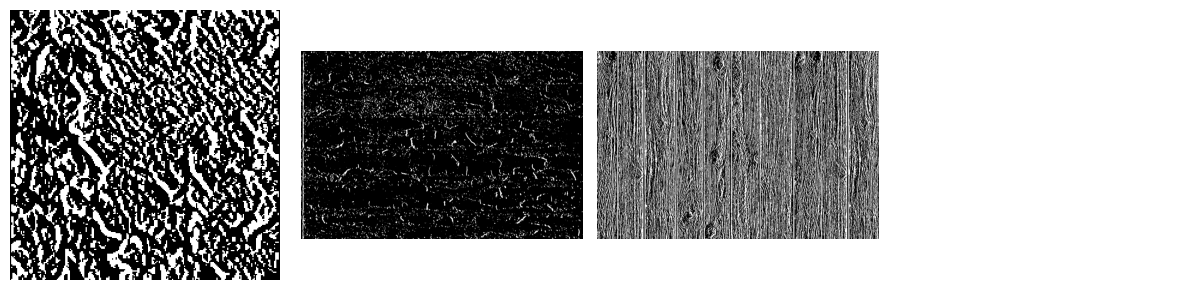

In [28]:
visualize(gabor_images)

##### <b>Gabor</b> texture analysis is a method that utilizes Gabor filters to analyze and characterize texture patterns in images.
##### Effects of Parameter Variation:
<ul>
    <li>
    <b>Texture Sensitivity</b>: Adjusting `ksize`, `sigma`, and `lambd` affects the scale at which textures are captured. Smaller values tend to capture finer details, while larger values capture broader textures.
    </li></br>
    <li>
    <b>Directional Sensitivity</b>: Changing `theta` allows focusing on different directional textures. This parameter captures textures oriented along specific angles.
    </li></br>
    <li>
    <b>Spatial Filtering Characteristics</b>: Altering `gamma` modifies the filter's aspect ratio, impacting the filter's directional sensitivity.
    </li></br>
</ul>

##### Observations during Analysis:
<ul>
    <li>
    <b>Texture Detail</b>: Smaller `ksize`, `sigma`, and `lambd` values emphasize finer details but might introduce noise.
    </li></br>
    <li>
    <b>Orientation Sensitivity</b>: Different `theta` values can capture different directional textures, useful for images with predominant orientations.
    </li></br>
    <li>
    <b>Trade-off Between Detail and Smoothness</b>: Balancing `sigma` between high and low values can adjust the trade-off between detail preservation and noise reduction.
    </li>
</ul>

## Question 4

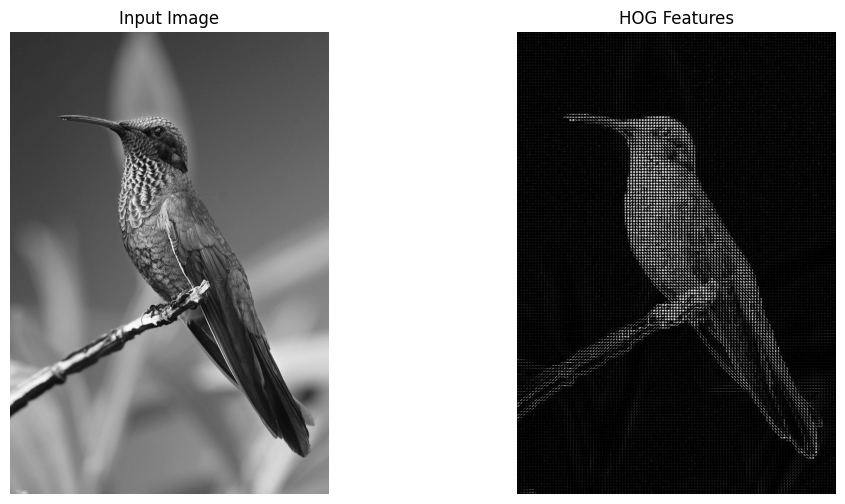

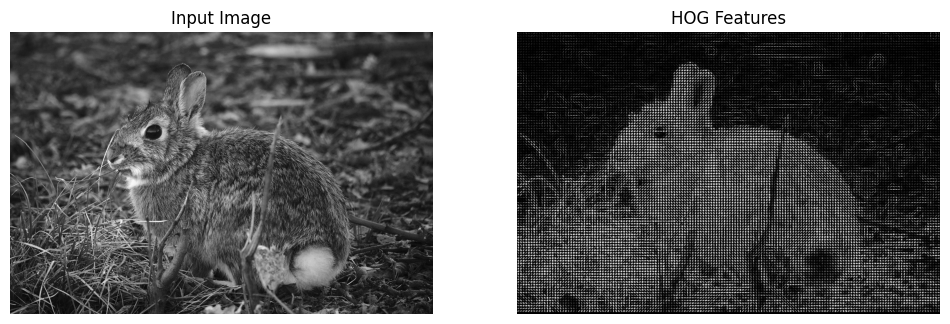

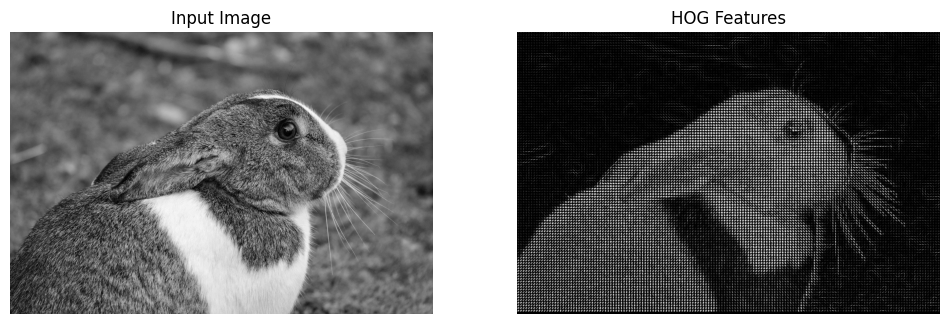

In [5]:
def create_hog(images):
    """
    Computes Histogram of Oriented Gradients (HOG) features for a set of input images.

    Args:
    - images: List of input images in RGB format

    Returns:
    - hog_images: List of HOG feature representations of the input images
    """
    
    hog_images = []
    
    for image in images:
        
        # Convert the RGB image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Compute HOG features and HOG image visualization
        hog_features, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')


        # Display the original image and its corresponding HOG features visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
        ax1.axis('off')
        ax1.imshow(gray_image, cmap=plt.cm.gray)
        ax1.set_title('Input Image')
        
        # Rescale intensity for better visualization of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)

        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('HOG Features')

        plt.show()
    return hog_images


images4 = load_dataSet("./images/4")
hog_images = create_hog(images4)

The Histogram of Oriented Gradients, also known as HOG, is a feature descriptor widely used in computer vision and image processing for object detection.</br>
The technique counts occurrences of gradient orientation in the localized portion of an image.</br>

Algorithm:
<ol>
    <li>Gradient Calculation:</br>
        Compute the gradient of the image using horizontal and vertical filters (e.g., Sobel filters).</br>
        Calculate the magnitude and orientation of the gradient at each pixel.
    </li></br>
    <li>Cell Division:</br>
        Divide the image into small cells (e.g., 8x8 pixel cells)
    </li></br>
    <li>Histograms:</br>
        For each cell, create a histogram of gradient orientations. The histogram bins represent different orientation ranges</br>
        (0-180 degrees), and the values in each bin correspond to the magnitude of gradients within that orientation range.
    </li></br>
    <li>Block Normalization:</br>
        Combine adjacent cells into blocks and normalize the histograms within each block to enhance robustness against lighting.
    </li></br>
    <li>Descriptor Formation:</br>
        Concatenate the normalized block histograms to form the final descriptor for the image.
    </li>
</ol>

Parameters:
<ol>
    <li><b>orientations</b>:</br>
        This parameter determines the number of gradient orientation bins to be used in feature computation. Increasing orientations</br>
        leads to a more detailed representation of gradient directions in the image. More orientations allow capturing finer gradient variations</br> but also increase feature dimensionality.
     </li></br>
    <li><b>pixels_per_cell</b>:</br>
        Increasing this parameter value leads to larger cell sizes for computing gradients, resulting in coarser features. Larger cell sizes</br>
        may capture more global or larger-scale patterns in the image, but they might lose finer details. Smaller pixels_per_cell values capture</br> finer details but increase computational requirements.
    </li></br>
    <li><b>cells_per_block</b>:</br>
        Increasing this parameter creates larger blocks by grouping more cells together. Larger blocks capture more spatial information and</br> context but might lose localized details. Smaller cells_per_block values result in more blocks and may capture finer local details but</br> may increase noise sensitivity.
    </li>
</ol>

Increasing these parameters often results in more detailed and richer feature representations, capturing more intricate patterns and structures in the image. However, larger values may also increase computational cost and memory requirements.

It's essential to strike a balance between capturing fine details and maintaining computational efficiency based on the specific requirements of the application and the nature of the images being analyzed.

## Question 5

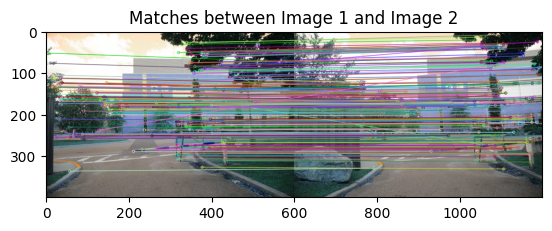

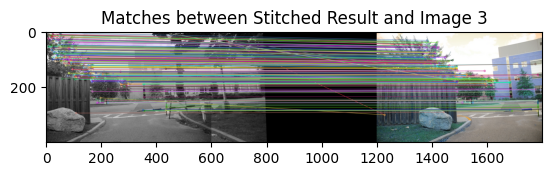

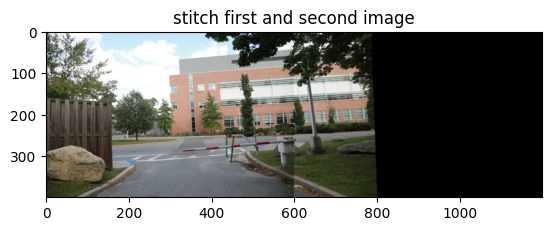

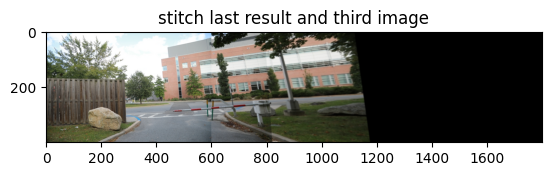

In [27]:
def sift(images):
    """
    Performs image stitching using the SIFT algorithm for a sequence of images.

    Args:
    - images: List of input images (at least three images)

    Returns:
    - Displays the stitched images: First the stitched result of the first and second images,
      then the stitched result of the previous result and the third image
    """ 
    
    img1_ = images[2]
    img2_ = images[1]
    img3_ = images[0]
    
    # Convert images to grayscale
    img1 = cv2.cvtColor(img1_, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_, cv2.COLOR_BGR2GRAY)
    img3 = cv2.cvtColor(img3_, cv2.COLOR_BGR2GRAY)
    
    # Create SIFT detector and compute keyPoints and descriptors for each image
    sift = cv2.SIFT_create(nfeatures=1000, nOctaveLayers=5, contrastThreshold=0.04, edgeThreshold=10)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    kp3, des3 = sift.detectAndCompute(img3, None)
    
    # Perform matching using BFMatcher between the keyPoints of img1 and img2
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Filter matches based on Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
      
    # Check if enough good matches are found for image stitching       
    if len(good) >= 4:
        
        # Obtain corresponding points in img1 and img2 for homography estimation
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        
        # Estimate homography between img1 and img2 using RANSAC
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp img1 to match perspective with img2 and create the initial stitched image
    dst = cv2.warpPerspective(img1_, H, (img2_.shape[1] + img1_.shape[1], img2_.shape[0]))
    dst[0:img2_.shape[0], 0:img2_.shape[1]] = img2_
    
    # Visualize matches between img1 and img2
    img_matches = cv2.drawMatches(img1_, kp1, img2_, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_matches), plt.title("Matches between Image 1 and Image 2"), plt.show()

    # Convert the resulting stitched image to grayscale for further processing
    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    
    # Perform stitching with the third image
    kp_b, des_b = sift.detectAndCompute(dst_gray, None)
    
    bf1 = cv2.BFMatcher()
    new_matches = bf1.knnMatch(des_b, des3, k=2)
    
    new_good = []
    for m ,n in new_matches:
        if m.distance < 0.75 * n.distance:
            new_good.append(m)
            
    if len(good) >= 4:
        
        new_src_pts = np.float32([kp_b[m.queryIdx].pt for m in new_good]).reshape(-1, 1, 2)
        new_dst_pts = np.float32([kp3[m.trainIdx].pt for m in new_good]).reshape(-1, 1, 2)

        H, _ = cv2.findHomography(new_src_pts, new_dst_pts, cv2.RANSAC, 5.0)

    # Warp the previously stitched image with the third image and create the final stitched result
    new_dst = cv2.warpPerspective(dst, H, (img3_.shape[1] + dst.shape[1], img3_.shape[0]))
    new_dst[0:img3_.shape[0], 0:img3_.shape[1]] = img3_
    
    # Visualize matches between the stitched image (dst) and img3
    new_img_matches = cv2.drawMatches(dst_gray, kp_b, img3_, kp3, new_good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(new_img_matches), plt.title("Matches between Stitched Result and Image 3"), plt.show()

    plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)),plt.title("stitch first and second image"),plt.show()
    plt.imshow(cv2.cvtColor(new_dst, cv2.COLOR_BGR2RGB)),plt.title("stitch last result and third image"),plt.show()

        
images5 = load_dataSet("./images/5")
sift(images5) 

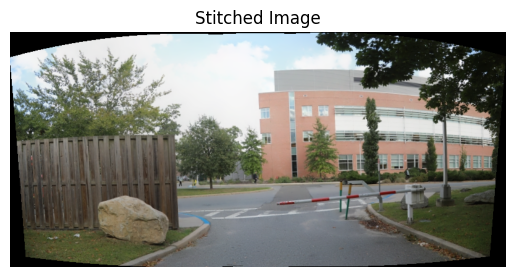

In [9]:
def sift2(images):
    """
    Performs image stitching using the OpenCV Stitcher class for a sequence of images.

    Args:
    - images: List of input images (at least three images)

    Returns:
    - Displays the stitched image using the OpenCV Stitcher
    """
    
    # Create a Stitcher object
    st = cv2.Stitcher_create()
    
    # Attempt to stitch the images using the Stitcher object
    error, stitched = st.stitch(images)

    # If stitching is successful, display the stitched image
    if not error:
        stitched_rgb = cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB)
        plt.imshow(stitched_rgb)
        plt.title("Stitched Image")
        plt.axis('off')
        plt.show()
        
sift2(images5)

Steps of stitching:
<ol>
    <li>Detection (Identify the interest points):</br>
        Local features are often detected at points in an image that stand out in terms of intensity, texture, etc.</br>
        Common methods for feature detection include</br>
        corner detectors (e.g., Harris corner detector) and blob detectors (e.g., Difference of Gaussians).
    </li></br>
    <li>Description (Extract vector feature descriptor surrounding each interest point):</br>
        Once key points are detected, local features are described to capture the distinctive information around those points.</br>
        Descriptors are typically based on the local intensity gradients or other relevant information.</br>
        The goal is to create a compact and informative representation of the local region around each key point.
    </li></br>
    <li>Matching (Determining the corresponding descriptors between the two views):</br>
        Local features are often used for matching corresponding points between different images.</br>
        Matching involves comparing the descriptors of key points in one image with those in another to find correspondences.
    </li>
</ol>

<b>SIFT:</b></br>
The SIFT (Scale-Invariant Feature Transform) algorithm is a computer vision technique used for feature detection and description. </br>
It detects distinctive key points or features in an image that are robust to changes in scale, rotation, and affine transformations.</br>
SIFT works by identifying key points based on their local intensity extrema and computing descriptors that capture the local image information around those key points.</br></br>
<b>RANSAC:</b></br>
Once local features are detected and described using descriptors, the next step is often descriptor matching.</br>
Matching involves finding correspondences between descriptors in different images, enabling tasks such as image alignment and object recognition.


Parameters:
<ol>
    <li>Matching Parameters:</br>
        Lowe's Ratio Test Threshold: Adjusting this threshold can impact the number and quality of matches. Try different values to filter the matches appropriately.
    </li></br>
    <li>Homography Estimation:</br>
        RANSAC Threshold: The RANSAC threshold (set to 5.0) affects the tolerance level for outliers during homography estimation. Changing this value might improve the robustness of the homography estimation.
    </li></br>
    <li>Feature Detection and Descriptor Parameters:</br>
        SIFT Parameters: The SIFT algorithm has several parameters like 'nfeatures', 'nOctaveLayers', 'contrastThreshold', and 'edgeThreshold'. Tweaking these parameters might improve feature detection and matching.
    </li>
</ol>

parameters of create sift:
<ol>
    <li>nfeatures: This parameter controls the number of keypoints detected in an image.</br></br>
        Increase: Higher nfeatures might result in more keypoints being detected, capturing more details in the image. It can lead to better feature matching but might also increase computational complexity.</br>
        Decrease: Reducing nfeatures might limit the number of keypoints, potentially missing smaller or less prominent features in the images. This reduction could simplify the matching process but might lose important details.
    </li></br>
    <li>nOctaveLayers: Determines the number of layers within each octave of the scale pyramid.</br></br>
        Increase: Adding more layers might increase the scale space sampled for keypoints. This can capture keypoints at different scales, potentially improving the robustness of feature detection. However, it might increase computational overhead.
        Decrease: Reducing the number of layers might simplify the scale space considered for keypoints, potentially missing keypoints at various scales. This might make the algorithm less robust in detecting features across different scales.
    </li></br>
    <li>contrastThreshold: Sets the threshold for rejecting low-contrast keypoints.</br></br>
        Increase: Raising this threshold might filter out keypoints with low contrast, potentially focusing on more distinct features. It could improve the quality of matches by prioritizing keypoints with higher contrast.</br>
        Decrease: Lowering the threshold may include keypoints with lower contrast, which might lead to more keypoints being detected. However, this might also result in detecting less distinct or noisy keypoints.
    </li></br>
    <li>edgeThreshold: Defines the threshold for rejecting edge-like keypoints.</br></br>
        Increase: Raising the edgeThreshold could filter out keypoints lying on edges or corners, focusing on more stable keypoints away from edges. This might enhance the robustness of keypoints.
        Decrease: Reducing this threshold might include more edge-like keypoints. This could result in more keypoints but might also introduce less stable or less reliable keypoints.
    </li>
</ol>